# Distance-Based Embeddings on the Zachary Karate Club Network

This notebook illustrates the main ideas from the **distance-based embedding** lecture using the classic **Zachary Karate Club** network.

We will:

1. Load the Zachary network and visualize a standard **spring layout**.
2. Treat the spring layout as a (heuristic) embedding and build the $2\times n$ embedding matrix $X_2$ from node coordinates.
3. Build the **Shortest-path distance** matrix.
4. Visualize each distance matrix as a heatmap.
5. Compute the **2D  and 3D embeddings**.

---

> **Note (pedagogical):** the spring layout is primarily a visualization heuristic; the distance-based embeddings below are derived from well-defined pairwise distances.


In [1]:
# Core imports
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Reproducibility
SEED = 8
rng = np.random.default_rng(SEED)

print("Imports loaded. SEED =", SEED)


Imports loaded. SEED = 8


## 1. Load the Zachary Karate Club graph

NetworkX provides the Zachary network as a built-in dataset. This graph is undirected and unweighted.

- Nodes represent members of a karate club.
- Edges represent friendships.
- The graph famously split into two factions (often used as a ground-truth community label).


In [2]:
G = nx.karate_club_graph()
n = G.number_of_nodes()
m = G.number_of_edges()

print(f"Zachary Karate Club graph: n={n}, m={m}, directed? {G.is_directed()}")

club = nx.get_node_attributes(G, "club")
unique_clubs = sorted(set(club.values()))
print("Club labels:", unique_clubs)


Zachary Karate Club graph: n=34, m=78, directed? False
Club labels: ['Mr. Hi', 'Officer']


## 2. Spring layout (visualization)

We start with the **spring layout** (force-directed layout). This produces coordinates in $\mathbb{R}^2$ that are convenient for visualization.

> Important: a spring layout is not derived from a graph distance matrix in a principled way, and it can vary with initialization and parameters.


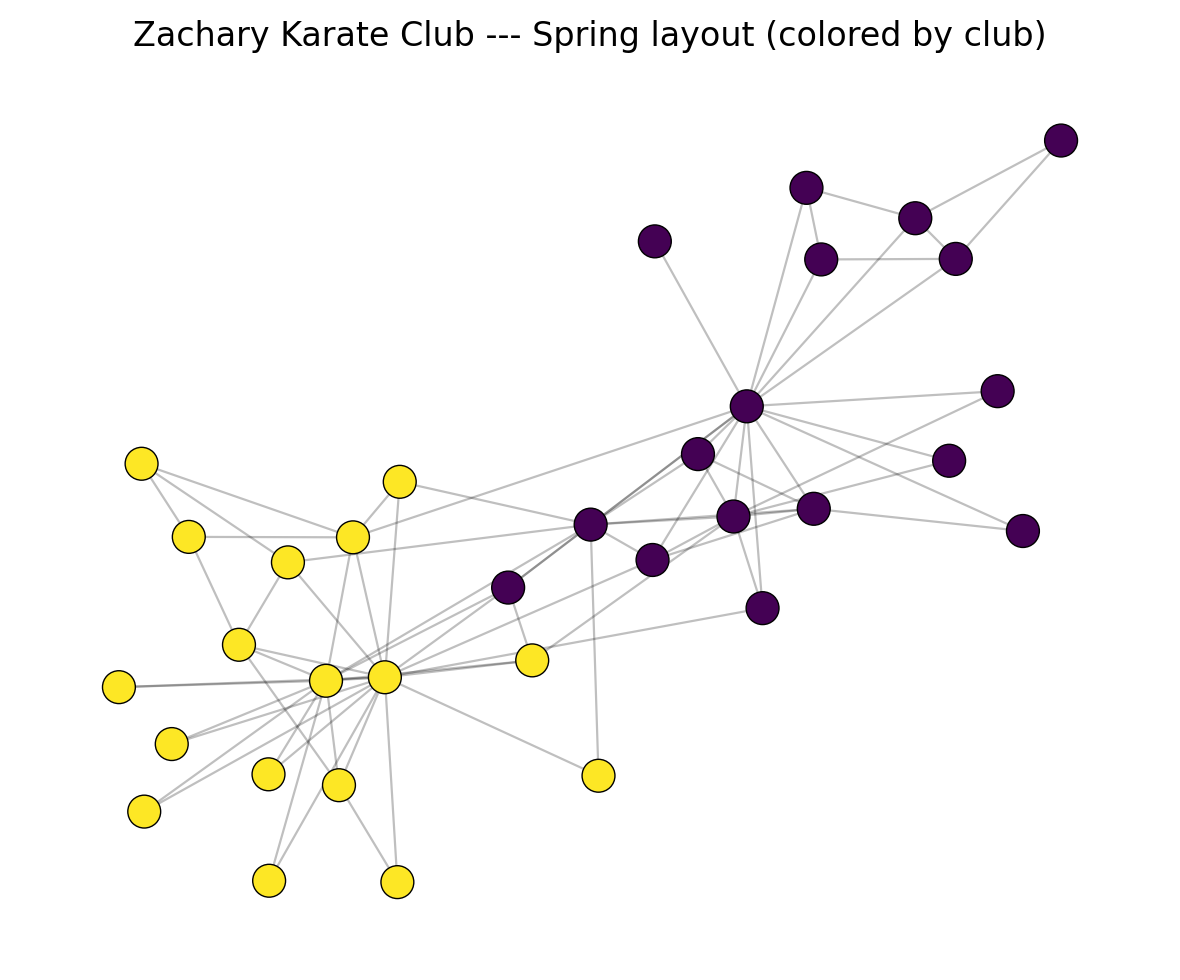

In [3]:
pos_spring = nx.spring_layout(G, seed=SEED)

# Color nodes by faction for visual reference (2 colors)
club_color = {"Mr. Hi": 0, "Officer": 1}
node_colors = [club_color[club[i]] for i in G.nodes()]

plt.figure(figsize=(6, 5), dpi=200)
nx.draw_networkx_edges(G, pos_spring, alpha=0.25, width=0.8)
nx.draw_networkx_nodes(G, pos_spring, node_color=node_colors, node_size=140, edgecolors="black", linewidths=0.5)
plt.title("Zachary Karate Club --- Spring layout (colored by club)")
plt.axis("off")
plt.tight_layout()
plt.show()


The coloring in the figure above reflects the **ground truth partition**, namely the two factions of the club that ultimately split following the conflict.

## 3. The $2\times n$ embedding matrix $X_2$ from the spring layout

Given a 2D layout with coordinates $\textbf{x}_i \in \mathbb{R}^2$ for each node $i$, we can assemble the embedding matrix

$$
X_2 = \begin{bmatrix} \textbf{x}_1 & \textbf{x}_2 & \cdots & \textbf{x}_n \end{bmatrix}\in\mathbb{R}^{2\times n}.
$$

Here the **columns** are the node coordinates on the plane.


In [4]:
# Assemble X2 with columns as node coordinates (ordered by node index)
X2_spring = np.vstack([[pos_spring[i][0] for i in range(n)],
                       [pos_spring[i][1] for i in range(n)]])

print("X2_spring shape:", X2_spring.shape)
print("First 8 columns of X2_spring:\n", np.round(X2_spring[:, :8], 4))


X2_spring shape: (2, 34)
First 8 columns of X2_spring:
 [[0.3412 0.3175 0.0642 0.46   0.4732 0.6401 0.7119 0.2546]
 [0.3386 0.0644 0.0443 0.0836 0.7041 0.8067 0.7055 0.2197]]


## 4. Viewing the Spring Layout as a Geometric Embedding

We now explicitly interpret the spring layout as a mapping

$$
\Phi : \mathcal{V} \rightarrow \mathbb{R}^2,
\qquad
i \mapsto \mathbf{x}_i.
$$

Each node $i$ is assigned coordinates
$\mathbf{x}_i = (x_{1,i}, x_{2,i})^\top$.

In the next plot:

- The horizontal axis represents $x_1$.
- The vertical axis represents $x_2$.
- The grid highlights that nodes now live in a **metric space**.
- Euclidean distances between points can now be computed directly.

> Important: this embedding is obtained from a visualization heuristic (spring layout).
> Later embeddings will be derived from **well-defined graph distances**.

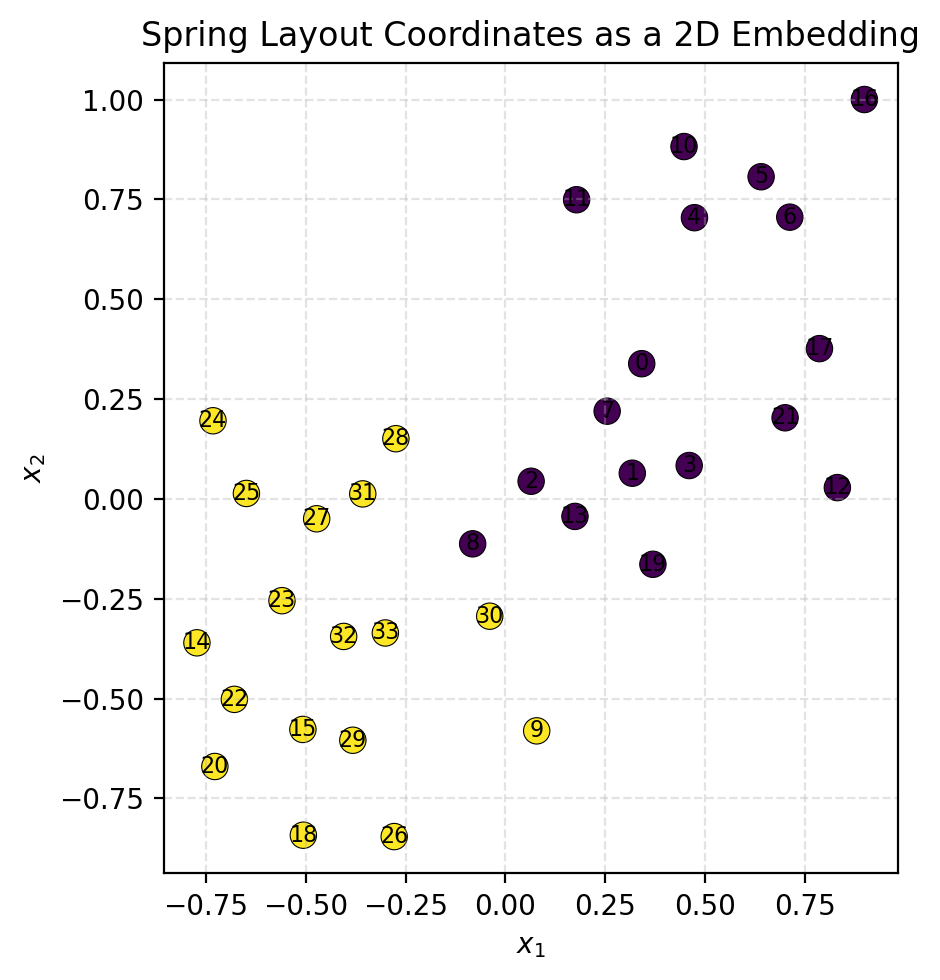

In [5]:
# ------------------------------------------------------------
# 2D scatter plot of node coordinates (embedding view)
# ------------------------------------------------------------

# Extract coordinates from the spring layout
x_vals = X2_spring[0, :]
y_vals = X2_spring[1, :]

plt.figure(figsize=(7, 5), dpi=200)

# Scatter plot (colored by ground-truth faction for reference)
plt.scatter(
    x_vals,
    y_vals,
    c=node_colors,
    s=90,
    edgecolors="black",
    linewidths=0.4,
)

# Optional: annotate node indices (comment out if too busy)
for i in range(n):
    plt.text(x_vals[i], y_vals[i], str(i), fontsize=8, ha="center", va="center")

plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Spring Layout Coordinates as a 2D Embedding")
plt.grid(True, linestyle="--", alpha=0.35)

# Equal aspect helps interpret distances geometrically
plt.gca().set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()

## 5. Shortest-Path Distance Matrix

We now construct the pairwise **shortest-path distance matrix**

$$
D_{\mathrm{sp}} = [d_{\mathrm{sp}}(i,j)],
$$

where

$$
d_{\mathrm{sp}}(i,j)
$$

is the length (number of edges) of a shortest path between nodes $i$ and $j$.

For an undirected and connected graph:

- The matrix is **symmetric**.
- The diagonal entries are **zero**.
- The entries are **integers**.
- It satisfies the **metric axioms** (identity, symmetry, triangle inequality).

This matrix captures purely topological proximity in the network.

In [6]:
# ------------------------------------------------------------
# 5.1 Shortest-path distance matrix
# ------------------------------------------------------------

# Compute all-pairs shortest path lengths
lengths = dict(nx.all_pairs_shortest_path_length(G))

# Build the distance matrix
D_sp = np.zeros((n, n), dtype=float)
for i in range(n):
    for j in range(n):
        D_sp[i, j] = lengths[i][j]

print("Shortest-path distance matrix built.")
print("Range:", (D_sp.min(), D_sp.max()))

Shortest-path distance matrix built.
Range: (0.0, 5.0)


## 5.2 Visualizing the Shortest-Path Distance Matrix

A heatmap allows us to inspect the geometric structure induced by
shortest-path distances.

If communities are well separated, we often observe a **block structure**:
nodes within the same community tend to have smaller pairwise distances.

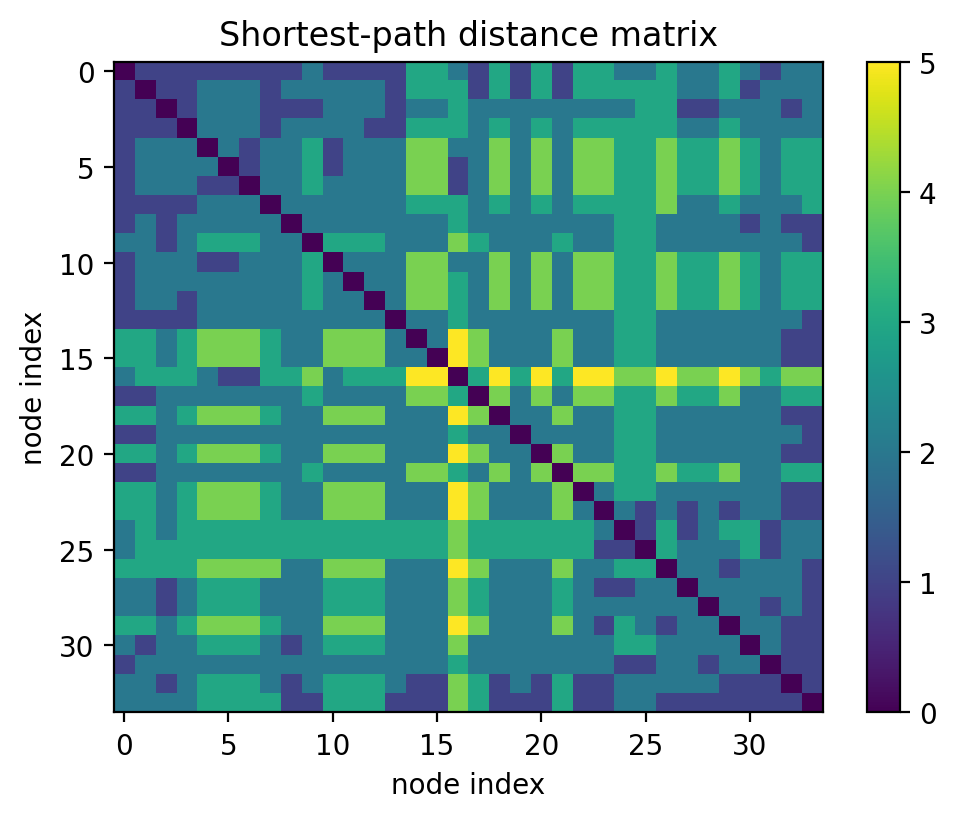

In [7]:
# ------------------------------------------------------------
# 5.2 Heatmap visualization
# ------------------------------------------------------------

plt.figure(figsize=(5.2, 4.2), dpi=200)
plt.imshow(D_sp, aspect="auto")
plt.colorbar()
plt.title("Shortest-path distance matrix")
plt.xlabel("node index")
plt.ylabel("node index")
plt.tight_layout()
plt.show()

## 6. Two embedding methods from shortest-path distances

We now compute 2D embeddings from the **shortest-path distance matrix** $D_{\mathrm{sp}}$ using two approaches:

### A) Stress minimization (metric MDS)

We approximately solve:

$$
\min_{\textbf{x}_1,\ldots,\textbf{x}_n\in\mathbb{R}^2}
\;\sum_{i<j}
\big(\|\textbf{x}_i-\textbf{x}_j\|_2 - d_{\mathrm{sp}}(i,j)\big)^2.
$$

We implement this using `sklearn.manifold.MDS` with
`dissimilarity="precomputed"`.

### B) Classical MDS (double-centering)

Given the squared distance matrix
$$
D^{(2)} = [d_{\mathrm{sp}}(i,j)^2],
$$

compute

$$
G = -\tfrac12 H D^{(2)} H,
\qquad
H = I - \tfrac1n \mathbf{1}\mathbf{1}^\top,
$$

then take the top $d$ eigenpairs of $G$ to recover coordinates in $\mathbb{R}^d$.

In [11]:
# ------------------------------------------------------------
# 6. Embeddings from shortest-path distances
# ------------------------------------------------------------

def stress_mds_embedding(D, dim=2, seed=SEED):
    """
    Metric MDS via stress minimization.
    Returns embedding as a (dim, n) matrix with columns as node coordinates.
    """
    mds = MDS(
        n_components=dim,
        dissimilarity="precomputed",
        random_state=seed,
        normalized_stress="auto",
        n_init=4,
        max_iter=400,
    )
    X = mds.fit_transform(D)   # shape: (n, dim)
    return X.T                 # convert to (dim, n)


def classical_mds_embedding(D, dim=2):
    """
    Classical MDS via double-centering and eigendecomposition.
    Returns embedding as a (dim, n) matrix with columns as node coordinates.
    """
    n = D.shape[0]
    D2 = D**2

    # Centering matrix
    H = np.eye(n) - (1.0 / n) * np.ones((n, n))

    # Gram matrix
    G = -0.5 * H @ D2 @ H

    # Eigendecomposition
    evals, evecs = np.linalg.eigh(G)

    # Sort in descending order
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]

    # Keep top-d eigenpairs
    evals_d = np.clip(evals[:dim], 0, None)
    evecs_d = evecs[:, :dim]

    # Coordinates
    X = np.diag(np.sqrt(evals_d)) @ evecs_d.T
    return X


# ------------------------------------------------------------
# Compute embeddings (shortest-path only)
# ------------------------------------------------------------

X2_stress_sp = stress_mds_embedding(D_sp, dim=2, seed=SEED)
X2_cmds_sp   = classical_mds_embedding(D_sp, dim=2)

print("Computed 2D embeddings from shortest-path distances using:")
print("  - Stress minimization (metric MDS)")
print("  - Classical MDS")

Computed 2D embeddings from shortest-path distances using:
  - Stress minimization (metric MDS)
  - Classical MDS


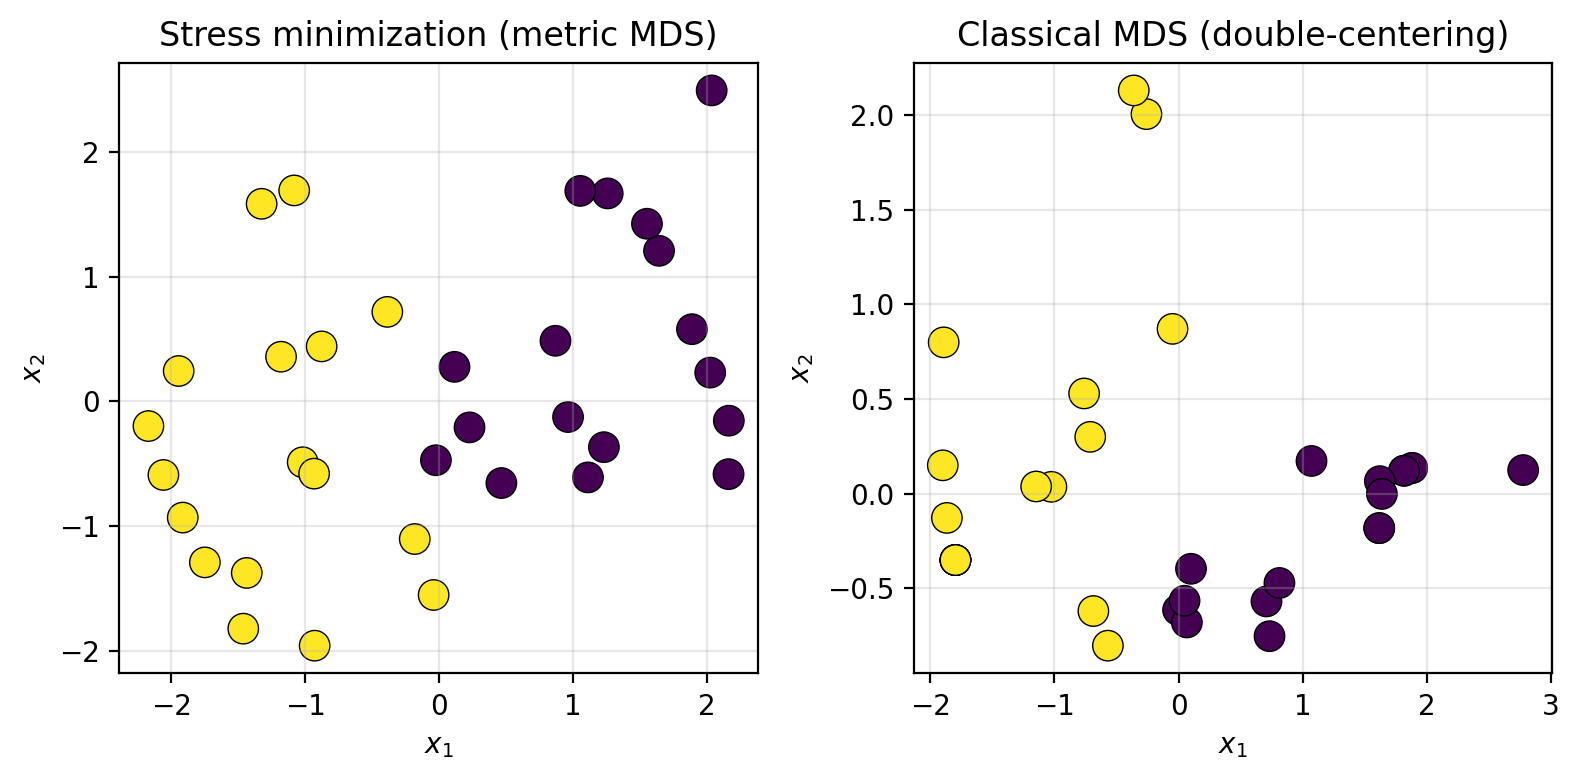

In [14]:
# ------------------------------------------------------------
# Compare the two 2D embeddings (shortest-path distance)
# ------------------------------------------------------------

plt.figure(figsize=(8, 4), dpi=200)

# ----- Panel 1: Stress MDS -----
plt.subplot(1, 2, 1)

X = X2_stress_sp  # shape (2, n)
plt.scatter(X[0, :], X[1, :], c=node_colors, s=120, edgecolors="black", linewidths=0.5)
plt.title("Stress minimization (metric MDS)")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.grid(alpha=0.3)

# ----- Panel 2: Classical MDS -----
plt.subplot(1, 2, 2)

X = X2_cmds_sp  # shape (2, n)
plt.scatter(X[0, :], X[1, :], c=node_colors, s=120, edgecolors="black", linewidths=0.5)
plt.title("Classical MDS (double-centering)")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6.1  Three-dimensional embeddings from shortest-path distances

We now repeat the same two embedding methods, but in **three dimensions** ($d=3$).

### A) Stress minimization (metric MDS)

We approximately solve:

$$
\min_{\textbf{x}_1,\ldots,\textbf{x}_n\in\mathbb{R}^3}
\;\sum_{i<j}
\big(\|\textbf{x}_i-\textbf{x}_j\|_2 - d_{\mathrm{sp}}(i,j)\big)^2.
$$

### B) Classical MDS (double-centering)

We again compute the Gram matrix

$$
G = -\tfrac12 H D^{(2)} H,
\qquad
H = I - \tfrac1n \mathbf{1}\mathbf{1}^\top,
$$

and recover coordinates in $\mathbb{R}^3$ from the top three eigenpairs.

In [15]:
# ------------------------------------------------------------
# 6.1 Compute 3D embeddings (shortest-path only)
# ------------------------------------------------------------

X3_stress_sp = stress_mds_embedding(D_sp, dim=3, seed=SEED)
X3_cmds_sp   = classical_mds_embedding(D_sp, dim=3)

print("Computed 3D embeddings from shortest-path distances using:")
print("  - Stress minimization (metric MDS)")
print("  - Classical MDS")
print("Shapes:", X3_stress_sp.shape, X3_cmds_sp.shape)  # both should be (3, n)

Computed 3D embeddings from shortest-path distances using:
  - Stress minimization (metric MDS)
  - Classical MDS
Shapes: (3, 34) (3, 34)


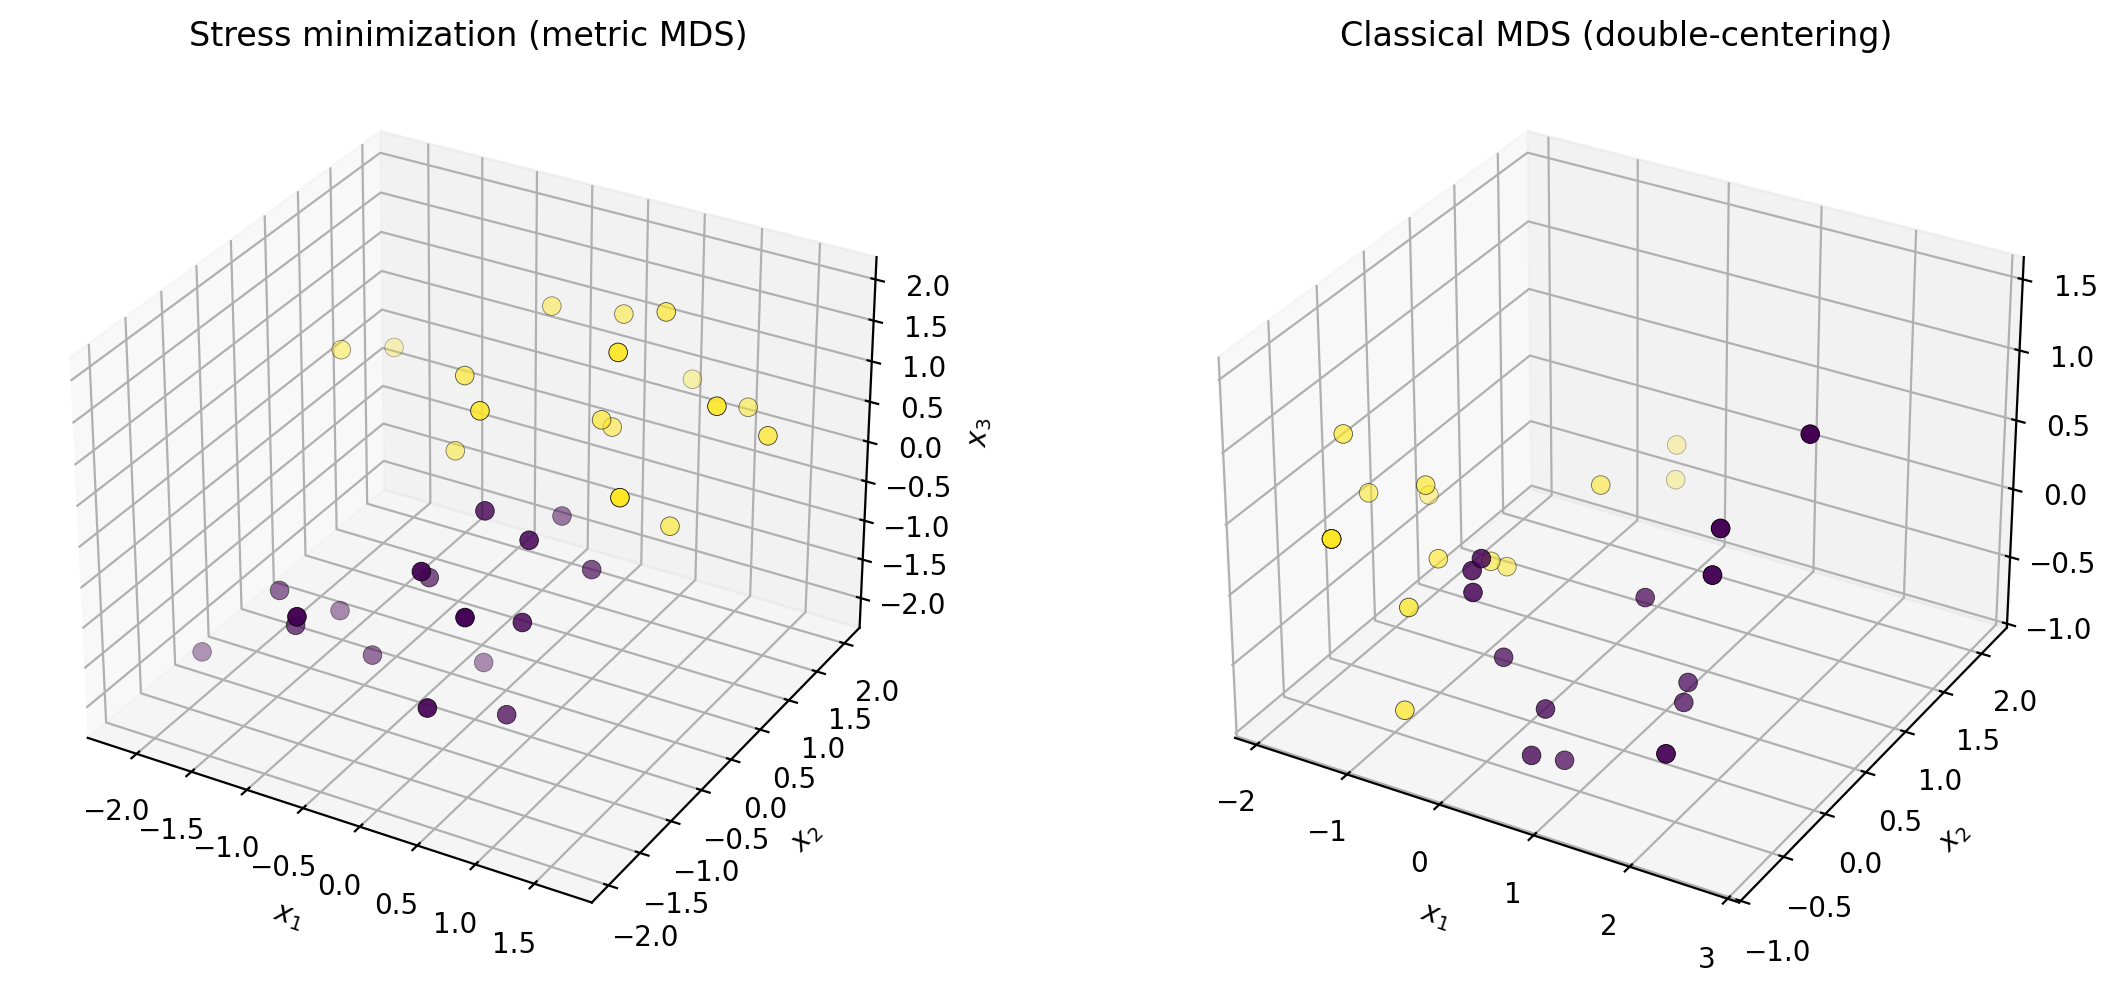

In [16]:
# ------------------------------------------------------------
# Compare the two 3D embeddings (shortest-path distance)
# ------------------------------------------------------------

fig = plt.figure(figsize=(12, 5), dpi=200)

# ----- Panel 1: Stress MDS -----
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
X = X3_stress_sp  # shape (3, n)
ax1.scatter(X[0, :], X[1, :], X[2, :], c=node_colors, s=45, edgecolors="black", linewidths=0.3)
ax1.set_title("Stress minimization (metric MDS)")
ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel(r"$x_2$")
ax1.set_zlabel(r"$x_3$")

# ----- Panel 2: Classical MDS -----
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
X = X3_cmds_sp  # shape (3, n)
ax2.scatter(X[0, :], X[1, :], X[2, :], c=node_colors, s=45, edgecolors="black", linewidths=0.3)
ax2.set_title("Classical MDS (double-centering)")
ax2.set_xlabel(r"$x_1$")
ax2.set_ylabel(r"$x_2$")
ax2.set_zlabel(r"$x_3$")

plt.tight_layout()
plt.show()

## 7. How embedding dimension $d$ affects quality: Stress vs. MDS truncation error

So far we have computed embeddings in low dimension (e.g., $d=2$ or $d=3$).
Now we study how the embedding quality changes as we increase the dimension $d$.

We track two quantities as a function of $d$:

1. **Stress (metric MDS)**
   This is the value of the stress objective minimized by metric MDS.
   As $d$ increases, stress should generally decrease because the embedding has more degrees of freedom.

2. **Truncation error (Classical MDS)**
   Classical MDS computes a centered Gram matrix $G$ and then keeps only the top $d$ eigenpairs.
   The discarded eigenvalues quantify how much geometric information is lost by truncation.

In the next cell we compute:
- $\text{Stress}(d)$ from metric MDS, and
- a relative Gram-matrix truncation error:
$$
\text{Err}(d)
=
\sqrt{
\frac{\sum_{k=d+1}^{n} \lambda_k^2}
     {\sum_{k=1}^{n} \lambda_k^2}
},
$$
where $\lambda_1 \ge \lambda_2 \ge \cdots \ge \lambda_n \ge 0$ are the eigenvalues of the Gram matrix $G$.

Computing Stress(d) and Err(d) for d = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


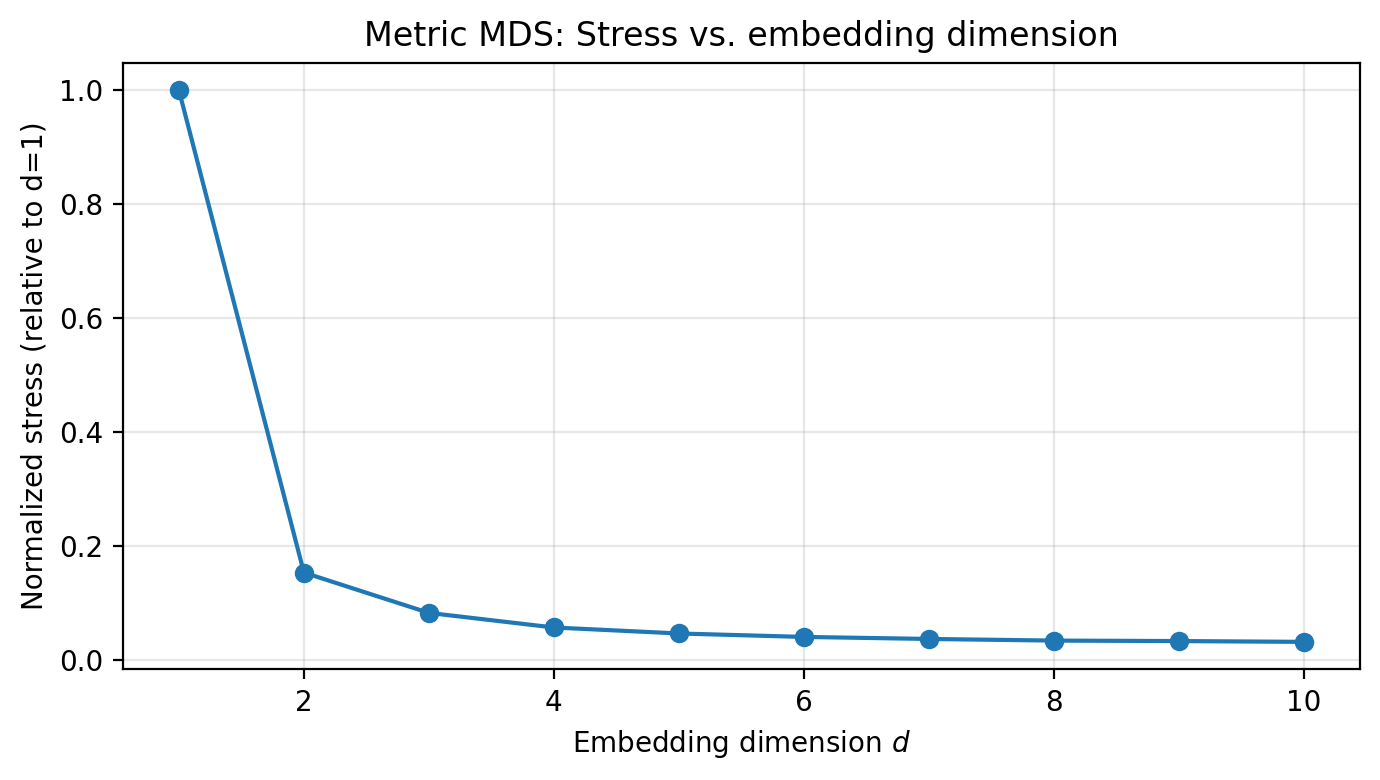

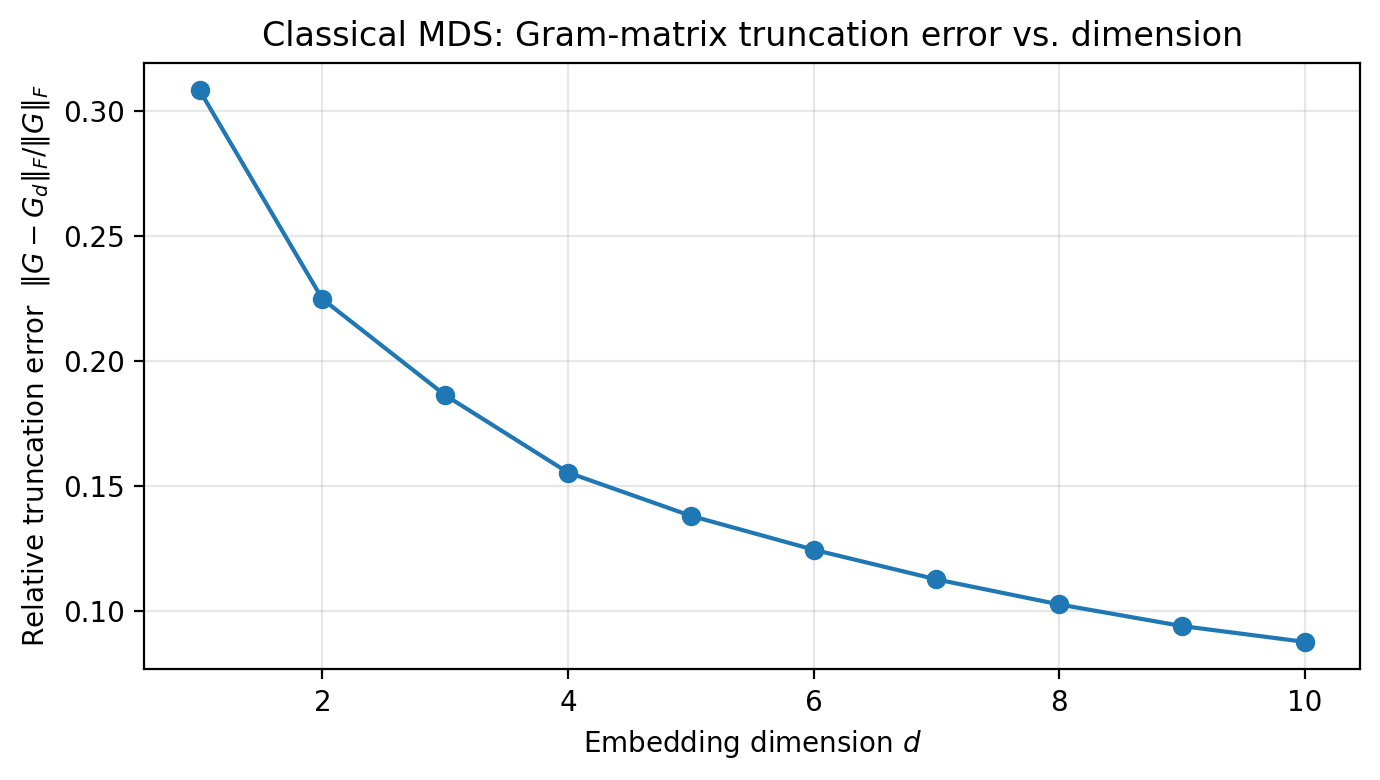


Summary table:
d | normalized stress | truncation error
 1 |           1.0000 |          0.3084
 2 |           0.1541 |          0.2248
 3 |           0.0834 |          0.1863
 4 |           0.0578 |          0.1553
 5 |           0.0473 |          0.1380
 6 |           0.0413 |          0.1244
 7 |           0.0377 |          0.1125
 8 |           0.0349 |          0.1025
 9 |           0.0340 |          0.0938
10 |           0.0326 |          0.0875


In [17]:
# ------------------------------------------------------------
# 7. Stress(d) and Classical MDS truncation error Err(d)
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS


# ---------- Helper: compute stress value for metric MDS ----------
def mds_stress_value(D, dim, seed=SEED, max_iter=400, n_init=4):
    """
    Fit metric MDS with precomputed distances and return the final stress value.
    Note: sklearn reports stress as the raw stress objective value.
    """
    mds = MDS(
        n_components=dim,
        dissimilarity="precomputed",
        random_state=seed,
        normalized_stress="auto",
        n_init=n_init,
        max_iter=max_iter,
    )
    _ = mds.fit_transform(D)
    return float(mds.stress_)


# ---------- Helper: build Gram matrix for classical MDS ----------
def classical_mds_gram(D):
    """
    Compute the centered Gram matrix G = -1/2 H D^2 H from a distance matrix D.
    """
    n = D.shape[0]
    D2 = D ** 2
    H = np.eye(n) - (1.0 / n) * np.ones((n, n))
    G = -0.5 * H @ D2 @ H
    return G


# Compute Gram matrix once (shortest-path distance)
G_sp = classical_mds_gram(D_sp)

# Eigenvalues of Gram matrix (symmetric)
evals, _ = np.linalg.eigh(G_sp)
evals = np.sort(evals)[::-1]  # descending

# Numerical safety: in exact Euclidean case, Gram eigenvalues should be >= 0.
# For graph distances, small negative eigenvalues can appear due to non-Euclidean effects.
evals_pos = np.clip(evals, 0, None)

# Denominator for relative Frobenius error in Gram space:
# ||G||_F^2 = sum_k lambda_k^2 for PSD G.
den = np.sum(evals_pos ** 2)
den = den if den > 0 else 1.0

# Choose a range of embedding dimensions
d_max = min(10, n - 1)  # feel free to increase (e.g., 20) for more detail
d_list = list(range(1, d_max + 1))

stress_vals = []
trunc_err_vals = []

print("Computing Stress(d) and Err(d) for d =", d_list)

for d in d_list:
    # 1) Stress from metric MDS
    s = mds_stress_value(D_sp, dim=d, seed=SEED, max_iter=400, n_init=4)
    stress_vals.append(s)

    # 2) Classical MDS truncation error in Gram space:
    # Best rank-d approximation keeps top d eigenvalues.
    # ||G - G_d||_F^2 = sum_{k>d} lambda_k^2  (for PSD G).
    tail = np.sum(evals_pos[d:] ** 2)
    err = np.sqrt(tail / den)
    trunc_err_vals.append(err)

# Convert to numpy arrays
stress_vals = np.array(stress_vals, dtype=float)
trunc_err_vals = np.array(trunc_err_vals, dtype=float)

# Normalize stress for display (optional but often helpful)
# (Raw stress scales with the magnitude/units of distances.)
stress_vals_norm = stress_vals / stress_vals[0] if stress_vals[0] > 0 else stress_vals

# ---------- Plot results ----------
plt.figure(figsize=(7, 4), dpi=200)
plt.plot(d_list, stress_vals_norm, marker="o")
plt.xlabel(r"Embedding dimension $d$")
plt.ylabel("Normalized stress (relative to d=1)")
plt.title("Metric MDS: Stress vs. embedding dimension")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4), dpi=200)
plt.plot(d_list, trunc_err_vals, marker="o")
plt.xlabel(r"Embedding dimension $d$")
plt.ylabel(r"Relative truncation error  $\|G-G_d\|_F / \|G\|_F$")
plt.title("Classical MDS: Gram-matrix truncation error vs. dimension")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- Print a small table ----------
print("\nSummary table:")
print("d | normalized stress | truncation error")
for d, s, e in zip(d_list, stress_vals_norm, trunc_err_vals):
    print(f"{d:2d} | {s:16.4f} | {e:15.4f}")

## Summary

In this notebook we:

- Compared a visualization-based embedding (spring layout) with embeddings derived from a **graph-theoretic distance**.
- Constructed the **shortest-path distance matrix** and visualized its structure.
- Computed low-dimensional embeddings using:
  - **Stress minimization (metric MDS)**
  - **Classical MDS (double-centering + eigendecomposition)**
- Compared 2D and 3D embeddings obtained from shortest-path distances.
- Studied how embedding quality depends on the dimension $d$ by:
  - Tracking the **stress value** as a function of $d$
  - Analyzing the **MDS truncation error**
    $$
    \text{Err}(d)
    =
    \sqrt{
    \frac{\sum_{k=d+1}^{n} \lambda_k^2}
         {\sum_{k=1}^{n} \lambda_k^2}
    }
    $$
    using partial sums of eigenvalues.

These experiments illustrate the trade-off between:

- **Geometric fidelity**
- **Embedding dimension**
- **Computational cost**